In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")

## 1. Basic Forecasting Workflows

In [21]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

Text(0, 0.5, 'Sıcaklık Değeri (◦R)')

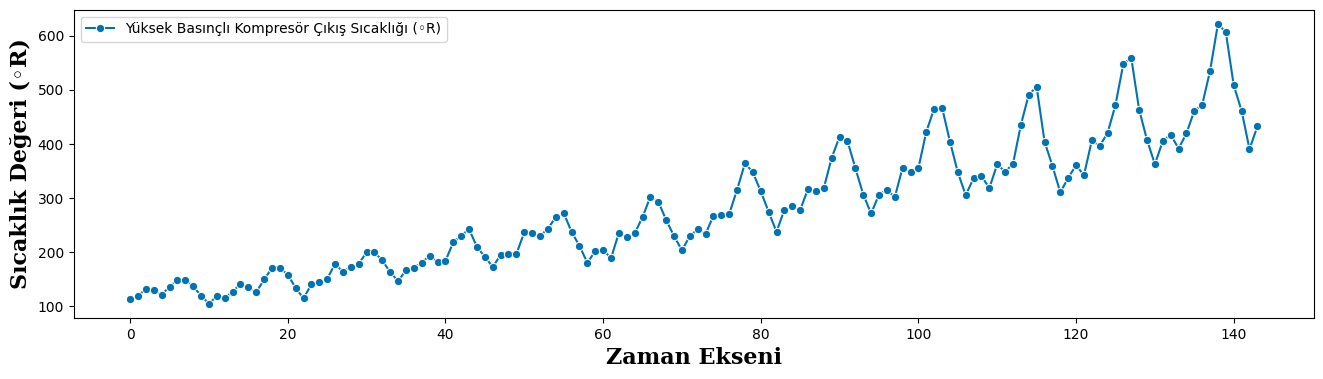

In [22]:
y = load_airline()

y.index=range(0,len(y.index))
# plotting for visualization
fig, ax = plot_series(
    y, labels=["Yüksek Basınçlı Kompresör Çıkış Sıcaklığı (◦R)"]
)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}
ax.set_xlabel(xlabel='Zaman Ekseni',fontdict=font)
ax.set_ylabel(ylabel='Sıcaklık Değeri (◦R)',fontdict=font)

## 1.1 Forecasting Horizon

In [24]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

In [26]:
# step 1: data specification
y = load_airline()
y.index=range(0,len(y.index))
# step 2: specifying forecasting horizon
fh = np.arange(1, 37)

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)

# step 4: fitting the forecaster
forecaster.fit(y)

# step 5: querying predictions
y_pred = forecaster.predict(fh)

Text(0, 0.5, 'Sıcaklık Değeri (◦R)')

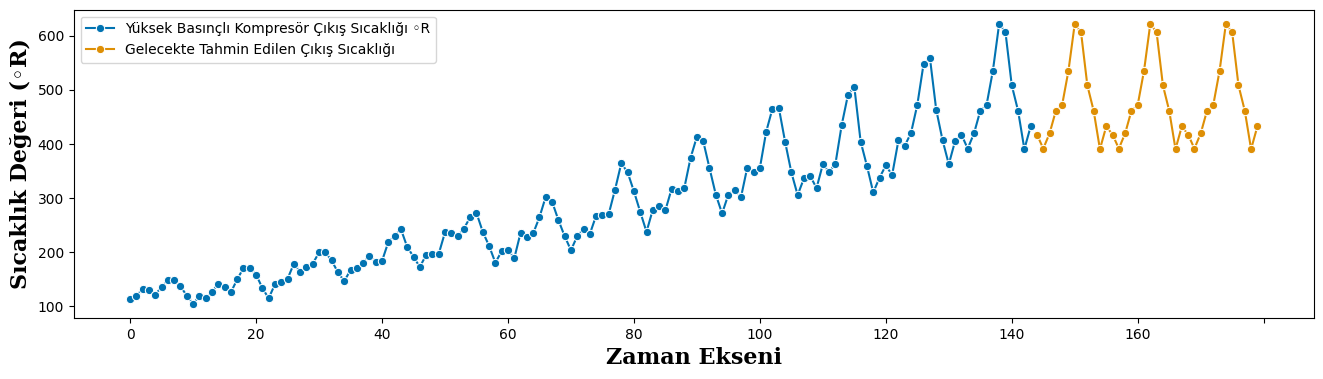

In [27]:
# optional: plotting predictions and past data
fig, ax = plot_series(
    y, y_pred, labels=["Yüksek Basınçlı Kompresör Çıkış Sıcaklığı ◦R", "Gelecekte Tahmin Edilen Çıkış Sıcaklığı"]
)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}
ax.set_xlabel(xlabel='Zaman Ekseni',fontdict=font)
ax.set_ylabel(ylabel='Sıcaklık Değeri (◦R)',fontdict=font)

## 1.2 Probabilistic Forecasting: prediction intervals, quantile, variance and distributional forecasts

In [28]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

# until fit, identical with the simple workflow
y = load_airline()

y.index=range(0,len(y.index))

In [29]:
fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

In [30]:
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)

Text(0, 0.5, 'Sıcaklık Değeri (◦R)')

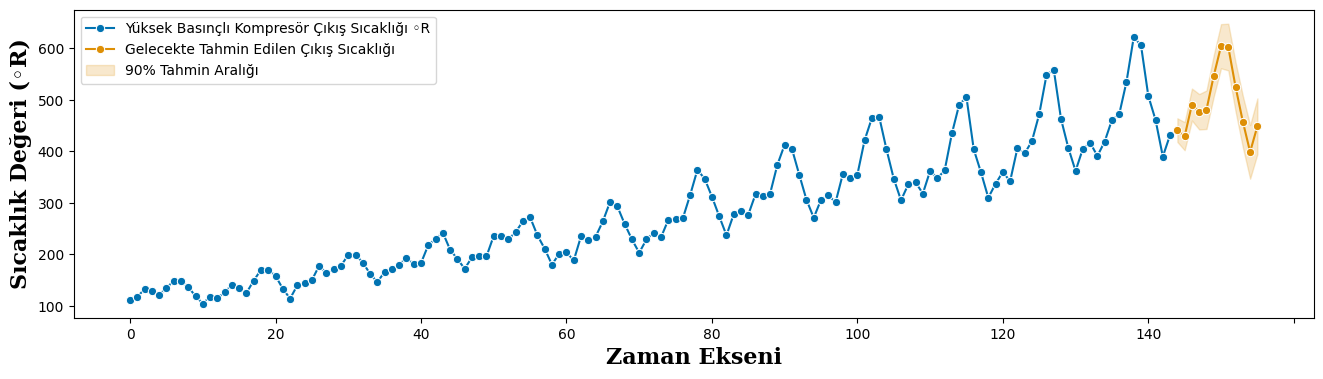

In [31]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(
    y, y_pred, labels=["Yüksek Basınçlı Kompresör Çıkış Sıcaklığı ◦R", "Gelecekte Tahmin Edilen Çıkış Sıcaklığı"], pred_interval=y_pred_ints
)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}
ax.set_xlabel(xlabel='Zaman Ekseni',fontdict=font)
ax.set_ylabel(ylabel='Sıcaklık Değeri (◦R)',fontdict=font)

## 1.2 Basic evaluation workflow - evaluating a batch of forecasts against ground truth observations

In [36]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [49]:
y = load_airline()
y.index=range(0,len(y.index))
y_train, y_test = temporal_train_test_split(y, test_size=36)

# we will try to forecast y_test from y_train

Text(32.093749999999986, 0.5, 'Sıcaklık Değeri (◦R)')

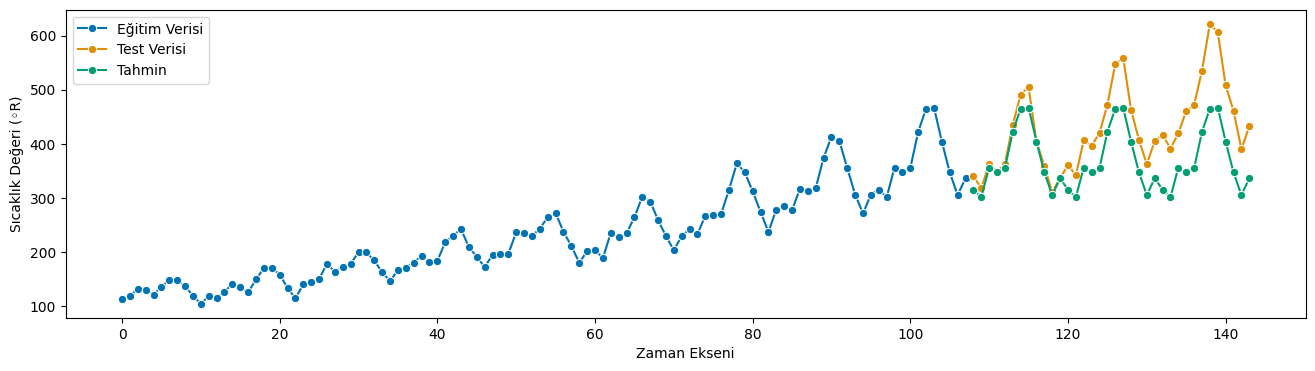

In [52]:
from sktime.utils import plotting
# we can simply take the indices from `y_test` where they already are stored
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="last", sp=12)

forecaster.fit(y_train)

# y_pred will contain the predictions
y_pred = forecaster.predict(fh)

plotting.plot_series(
    y_train, y_test, y_pred, labels=["Eğitim Verisi", "Test Verisi","Tahmin"], x_label="Zaman Ekseni", y_label="Sıcaklık Değeri (◦R)"
)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}
ax.set_xlabel(xlabel='Zaman Ekseni',fontdict=font)
ax.set_ylabel(ylabel='Sıcaklık Değeri (◦R)',fontdict=font)
# print(y_train.shape[0], y_test.shape[0])

## 1.3 Advanced Evaluation workflow: rolling re-sampling and aggregate errors, rolling back-testing

In [54]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

In [55]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

cv = ExpandingWindowSplitter(
    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72
)

df = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.061710,3.127072,0.006737,72,71
1,0.050042,3.629439,0.006827,84,83
2,0.029802,5.346899,0.021103,96,95
3,0.053773,2.283577,0.005722,108,107
4,0.073820,3.149801,0.006580,120,119
5,0.030976,6.890018,0.006569,132,131


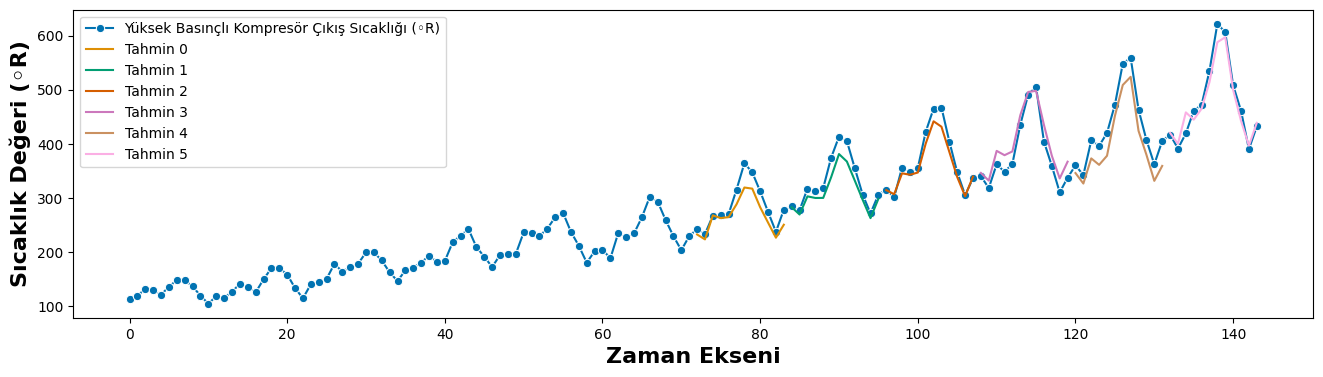

In [57]:
# visualization of a forecaster evaluation
fig, ax = plot_series(
    y,
    df["y_pred"].iloc[0],
    df["y_pred"].iloc[1],
    df["y_pred"].iloc[2],
    df["y_pred"].iloc[3],
    df["y_pred"].iloc[4],
    df["y_pred"].iloc[5],
    markers=["o", "", "", "", "", "", ""],
    labels=["Yüksek Basınçlı Kompresör Çıkış Sıcaklığı (◦R)"] + ["Tahmin " + str(x) + "" for x in range(6)]
)

font = {'weight' : 'bold',
        'size'   : 16}
ax.set_xlabel(xlabel='Zaman Ekseni',fontdict=font)
ax.set_ylabel(ylabel='Sıcaklık Değeri (◦R)',fontdict=font)
ax.legend();

## 1.4 Propabilistic Forecasting Interfaces

In [59]:
import numpy as np

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

# until fit, identical with the simple workflow
y = load_airline()

fh = np.arange(1, 13)
y.index=range(0,len(y.index))
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

In [60]:
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)


In [62]:
alpha = [0.1, 0.25, 0.5, 0.75, 0.9]
y_pred_quantiles = forecaster.predict_quantiles(alpha=alpha)

In [63]:
from sktime.utils import plotting

columns = [y_pred_quantiles[i] for i in y_pred_quantiles.columns]
len(columns)

5

Text(0, 0.5, 'Sıcaklık Değeri (◦R)')

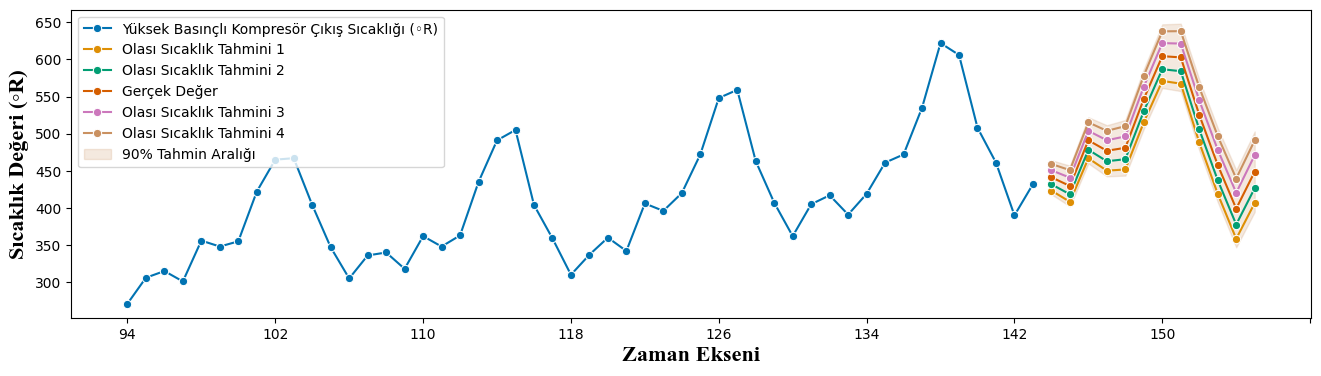

In [64]:
fig, ax = plotting.plot_series(y[-50:],labels=["Yüksek Basınçlı Kompresör Çıkış Sıcaklığı (◦R)","Olası Sıcaklık Tahmini 1","Olası Sıcaklık Tahmini 2","Gerçek Değer","Olası Sıcaklık Tahmini 3","Olası Sıcaklık Tahmini 4"], *columns, pred_interval=y_pred_ints,
)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
ax.set_xlabel(xlabel='Zaman Ekseni',fontdict=font)
ax.set_ylabel(ylabel='Sıcaklık Değeri (◦R)',fontdict=font)

## 1.5 Plot Windows

In [65]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

In [74]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Pencere Boyutu",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Tahmin Ufku",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Pencere Sayısı",
        xlabel="Zaman Ekseni",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]

    ax.legend(handles, labels);
    font = {
        'weight' : 'bold',
        'size'   : 16}
    ax.set_xlabel(xlabel='Zaman Ekseni',fontdict=font)
    ax.set_ylabel(ylabel='Sıcaklık Değeri (◦R)',fontdict=font)

In [75]:
# We are interested on a portion of the total data set.
# (for visualisatiion purposes)
y = load_airline().iloc[:30]
y.index=range(0,len(y.index))

In [76]:
y_train, y_test = temporal_train_test_split(y=y, test_size=0.25)
# set splitter parameters
window_length = 5
fh = ForecastingHorizon([1, 2, 3])

In [77]:
cv = SingleWindowSplitter(window_length=window_length, fh=fh)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 1


In [78]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

In [79]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)
cv

SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3], dtype='int64', is_relative=True),
                      window_length=5)

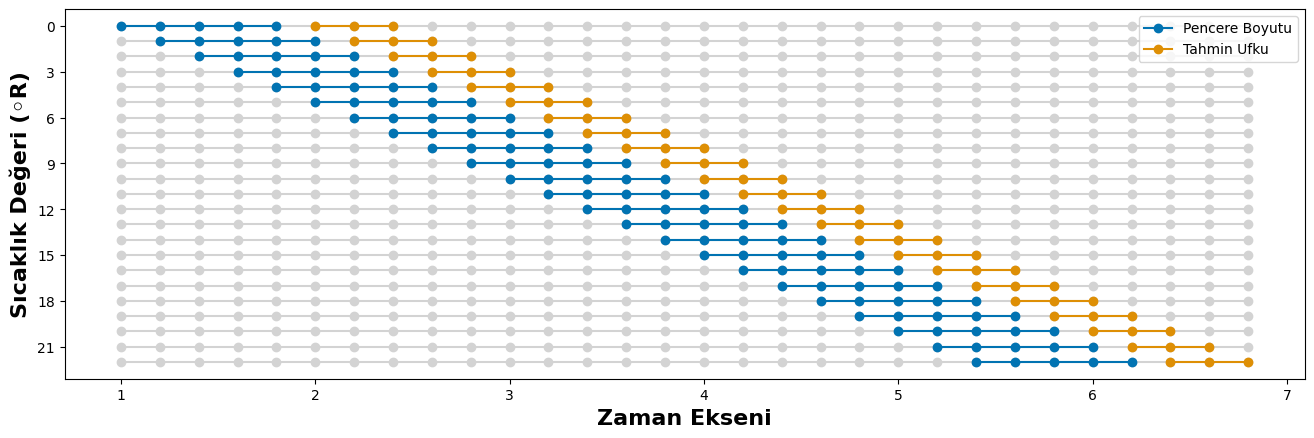

In [80]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [81]:
cv = ExpandingWindowSplitter(initial_window=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 23


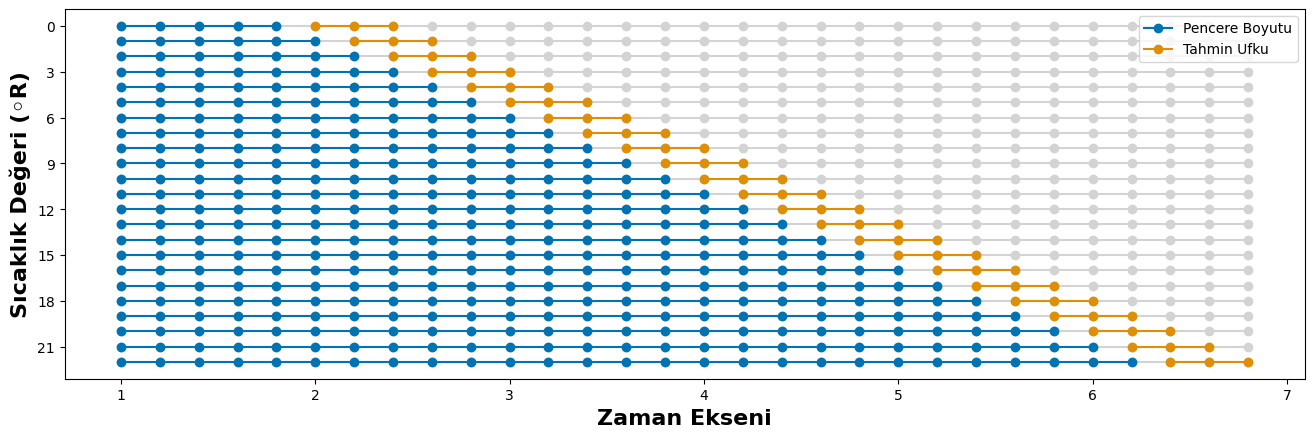

In [82]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

## 2. Advanced Composition: Pipelines, tuning, reduction

In [83]:
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# forecaster we want to tune
forecaster = ThetaForecaster()

# parameter grid to search over
param_grid = {"sp": [1, 6, 12]}

# evaluation/backtesting regime for *tuning*
fh = [1, 2, 3]  # fh for tuning regime, does not need to be same as in fit/predict!
cv = SlidingWindowSplitter(window_length=36, fh=fh)
scoring = PinballLoss()

# construct the composite forecaster with grid search compositor
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid, scoring=scoring, strategy="refit"
)

In [84]:
from sktime.datasets import load_airline

y = load_airline()[:60]

gscv.fit(y, fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3],
                                                 window_length=36),
                        forecaster=ThetaForecaster(),
                        param_grid={'sp': [1, 6, 12]}, scoring=PinballLoss())

In [85]:
gscv.best_params_

{'sp': 12}

In [86]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster, NaiveVariance

forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y)
gscv.best_params_

{'selected_forecaster': 'naive'}

In [87]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.impute import Imputer

In [88]:
data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [89]:
forecaster = ForecastingPipeline(
    steps=[
        ("imputer", Imputer(method="mean")),
        ("forecaster", ARIMA(suppress_warnings=True)),
    ]
)
forecaster.fit(y=y_train, X=X_train, fh=X_test.index[:5])
forecaster.predict_interval(X=X_test[:5])

0          
             0.9          
           lower     upper
Period                    
1997Q1  5.042704  6.119990
1997Q2  3.948564  5.235163
1997Q3  3.887471  5.253592
1997Q4  4.108211  5.506862
1998Q1  4.501319  5.913611